# EDA (aka Food)

PLS note that im too afraid to remove some values due to my inexperience and not understanding if some value is clearly an outlier for our case

In [1]:
!ls data

product_groups.txt     products_20201101.txt	  product_sum_20201001.txt
products_20200901.csv  products_sum_20200901.zip
products_20200901.txt  products_sum_20201101.zip


In [2]:
!head data/products_20200901.txt

In [3]:
import pandas as pd
from datetime import datetime

In [4]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [5]:
colunms = [s for s in 'date;id_doc;id_order;id_card;id_tov;id_kontr;quantity;sum;is_green'.split(';')]
colunms

['date',
 'id_doc',
 'id_order',
 'id_card',
 'id_tov',
 'id_kontr',
 'quantity',
 'sum',
 'is_green']

In [42]:
df = pd.read_csv(
    filepath_or_buffer='data/products_20200901.txt',
    header=0,
    sep=';',
    names = colunms,
    usecols = colunms,
    parse_dates=['date'],
    date_parser=dateparse
)
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271.0,"1,000",108,0
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271.0,"1,000",108,0
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271.0,"1,000","107,95",0
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271.0,"1,000",108,0
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97.0,"2,000",88,0


In [6]:
! ls ./data

product_groups.txt     products_20201101.txt	  product_sum_20201001.txt
products_20200901.csv  products_sum_20200901.zip
products_20200901.txt  products_sum_20201101.zip


In [7]:
! head ./data/product_groups.txt

In [8]:
products = pd.read_csv(
    filepath_or_buffer='data/product_groups.txt',
    sep=';'
)
products

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты
...,...,...,...
5645,40762,52194,Подарки и сувениры
5646,40763,52194,Подарки и сувениры
5647,40764,52194,Подарки и сувениры
5648,40765,52194,Подарки и сувениры


In [44]:
df.dtypes

date        datetime64[ns]
id_doc              object
id_order             int64
id_card             object
id_tov               int64
id_kontr           float64
quantity            object
sum                 object
is_green             int64
dtype: object

In [45]:
df.isnull().values.any()

True

There are some duplicates so let's quickly remove them

In [46]:
df.drop_duplicates(inplace=True)
len(df)

41763574

1. NaNs +
2. Customer outliers +
3. *Column* in terms frequency and amount - outliers +
4. How many goods of certain groups (of goods) +
5. Descriptives (discount, good preferences, preferences of group of good, etc.)

## NaNs

Checking for NaNs we can see that some values aren't set.

For the ids it can be just very big negative number (so the predictive model 'knows' that its not original)
For other values it can be replaced with mean, median (if they can be inferred for numbers) or some most common for strings (in this case it would be better to make an additional row that indicates that the value was missing in the original data)

If there aren't many rows they can be dropped

In [47]:
df.loc[:, df.isnull().any()].columns

Index(['id_kontr'], dtype='object')

In [56]:
df[df['id_kontr'].isnull()]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
73,2020-09-01 18:23:24,DCD681FA-67EC-EA11-B444-005056A7539A,0,1452280,185,NaN,"1,000",129,0
126,2020-09-01 18:45:27,1606023F-6BEC-EA11-B444-005056A7539A,0,4475695,372,NaN,"1,000",82,0
127,2020-09-01 20:55:22,AB82A13B-7DEC-EA11-B444-005056A7539A,0,5167781,372,NaN,"1,000",82,0
128,2020-09-01 20:45:49,AE21D94F-7BEC-EA11-B444-005056A7539A,0,9813162,372,NaN,"1,000",82,0
199,2020-09-01 14:53:45,03E52BAA-4AEC-EA11-B444-005056A7539A,0,7632871,647,NaN,"1,000",5,0
...,...,...,...,...,...,...,...,...,...
42100548,2020-09-30 09:55:46,8B9DC82F-EA02-EB11-B444-005056A7539A,0,3990786,37280,NaN,"2,000",110,0
42100659,2020-09-30 14:27:49,76AA193B-1003-EB11-B444-005056A7539A,0,0939821,27871,NaN,"1,000",70,0
42100660,2020-09-30 13:12:55,17B738C1-0603-EB11-B444-005056A7539A,0,a422949,27873,NaN,"1,000",100,0
42100661,2020-09-30 09:02:46,3210F0AF-E202-EB11-B444-005056A7539A,0,5004147,27873,NaN,"1,000",100,0


In [49]:
null_id_kontr = -9999

In [57]:
df.loc[df['id_kontr'].isnull(), 'id_kontr'] = null_id_kontr

In [59]:
df[df['quantity'].isnull()]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green


In [60]:
df[df['sum'].isnull()]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green


In [61]:
df[df['is_green'].isnull()]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green


## Customer

We would like to handle the customer, but firsly, let's convert quantity and sum to floats

In [75]:
df.quantity = df.quantity.str.replace(',', '.').astype(float)

In [77]:
df['sum'] = df['sum'].str.replace(',', '.').astype(float)

In [ ]:
df.id_card = df.id_card.str.strip()

In [18]:
df.to_csv('data/products_20200901.csv', index=False)

In [9]:
df = pd.read_csv('data/products_20200901.csv',
                 parse_dates=['date'],
                 date_parser=dateparse
                )

In [10]:
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271.0,1.0,108.00,0
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271.0,1.0,108.00,0
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271.0,1.0,107.95,0
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271.0,1.0,108.00,0
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97.0,2.0,88.00,0
...,...,...,...,...,...,...,...,...,...
41337219,2020-09-30 11:26:28,350DE9C7-F602-EB11-B444-005056A7539A,0,A465340,25292,17528.0,1.0,130.00,0
41337220,2020-09-30 08:12:39,6D7ACBFB-DB02-EB11-B444-005056A7539A,0,A698682,30740,19188.0,2.0,120.00,0
41337221,2020-09-30 09:54:24,F96D45E8-E902-EB11-B444-005056A7539A,0,7790662,30741,19188.0,1.0,73.00,0
41337222,2020-09-30 12:00:04,12067064-FB02-EB11-B444-005056A7539A,0,2751739,34835,15916.0,1.0,78.00,0


In [26]:
df.dtypes

date        datetime64[ns]
id_doc              object
id_order             int64
id_card             object
id_tov               int64
id_kontr           float64
quantity           float64
sum                float64
is_green             int64
dtype: object

Let's quickly check what interesting ideas we may want to see with our columns

In [27]:
test = df[:1000].copy()

In [36]:
test[['id_card', 'quantity', 'sum', 'is_green']].groupby('id_card').describe()

quantity                                                          \
              count      mean       std    min     25%    50%    75%    max   
id_card                                                                       
0002824         3.0  1.088000  0.871339  0.264  0.6320  1.000  1.500  2.000   
0022802         2.0  1.000000  0.000000  1.000  1.0000  1.000  1.000  1.000   
0025418         1.0  0.615000       NaN  0.615  0.6150  0.615  0.615  0.615   
0100060         2.0  1.000000  0.000000  1.000  1.0000  1.000  1.000  1.000   
0100435         3.0  1.333333  0.577350  1.000  1.0000  1.000  1.500  2.000   
...             ...       ...       ...    ...     ...    ...    ...    ...   
B700711         1.0  3.000000       NaN  3.000  3.0000  3.000  3.000  3.000   
B700734         3.0  1.000000  0.000000  1.000  1.0000  1.000  1.000  1.000   
B700738         6.0  0.936667  0.630551  0.186  0.5525  0.897  1.126  2.000   
B711974         2.0  1.000000  0.000000  1.000  1.0000  1.000  1.000  1.000   
B711976         1.0  1.000000       NaN  1.000  1.0000  1.000  1.000  1.000   

             sum              ...                   is_green            \
           count        mean  ...       75%     max    count      mean   
id_card                       ...                                        
0002824      3.0  154.013333  ...  220.3400  221.84      3.0  0.666667   
0022802      2.0   52.000000  ...   75.5000   99.00      2.0  0.000000   
0025418      1.0  123.980000  ...  123.9800  123.98      1.0  1.000000   
0100060      2.0   33.000000  ...   47.0000   61.00      2.0  0.000000   
0100435      3.0   86.333333  ...  127.0000  220.00      3.0  0.000000   
...          ...         ...  ...       ...     ...      ...       ...   
B700711      1.0  225.000000  ...  225.0000  225.00      1.0  0.000000   
B700734      3.0   54.266667  ...   78.9000  135.60      3.0  0.666667   
B700738      6.0   53.931667  ...   55.3275  147.00      6.0  0.000000   
B711974      2.0   25.430000  ...   27.0750   28.72      2.0  1.000000   
B711976      1.0    5.000000  ...    5.0000    5.00      1.0  0.000000   

                                              
                std  min  25%  50%  75%  max  
id_card                                       
0002824     0.57735  0.0  0.5  1.0  1.0  1.0  
0022802     0.00000  0.0  0.0  0.0  0.0  0.0  
0025418         NaN  1.0  1.0  1.0  1.0  1.0  
0100060     0.00000  0.0  0.0  0.0  0.0  0.0  
0100435     0.00000  0.0  0.0  0.0  0.0  0.0  
...             ...  ...  ...  ...  ...  ...  
B700711         NaN  0.0  0.0  0.0  0.0  0.0  
B700734     0.57735  0.0  0.5  1.0  1.0  1.0  
B700738     0.00000  0.0  0.0  0.0  0.0  0.0  
B711974     0.00000  1.0  1.0  1.0  1.0  1.0  
B711976         NaN  0.0  0.0  0.0  0.0  0.0  

[329 rows x 24 columns]

In [145]:
quantity_mean, quantity_std = df[['id_card', 'quantity']].groupby('id_card').mean(), df[['id_card', 'quantity']].groupby('id_card').std()

In [146]:
sum_mean, sum_std = df[['id_card', 'sum']].groupby('id_card').mean(), df[['id_card', 'sum']].groupby('id_card').std()

In [147]:
is_green_mean, is_green_std = df[['id_card', 'is_green']].groupby('id_card').mean(), df[['id_card', 'is_green']].groupby('id_card').std()

In [148]:
quantity_mean

,quantity
id_card,
0000000,1.142500
0000001,1.000000
0000003,1.333333
0000009,1.148765
0000015,1.081333
...,...
c539320,1.141143
c551708,1.523333
c633515,1.110969


In [149]:
quantity_mean.index[-1]

'undefin'

There is some undefined card! Interesting.

In [150]:
df[df.id_card=='undefin']

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
12186266,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,143,-9999.0,1.00,104.00,0
12186473,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,647,-9999.0,2.00,10.00,0
12186562,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,933,-9999.0,1.00,99.00,0
12186589,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,1087,-9999.0,2.00,112.00,0
12186951,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,18273,-9999.0,1.00,58.00,0
12187526,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,26439,-9999.0,2.00,268.00,0
12187703,2020-09-09 15:34:38,1E067BEC-98F2-EA11-B444-005056A7539A,5848568,undefin,32384,-9999.0,1.00,140.00,0
18478473,2020-09-14 20:11:59,C70F2B9D-AEF6-EA11-B444-005056A7539A,0,undefin,17823,12969.0,1.00,46.00,0
18478910,2020-09-14 20:11:59,C70F2B9D-AEF6-EA11-B444-005056A7539A,0,undefin,22984,16340.0,1.00,100.00,0
18892616,2020-09-14 20:58:31,A41592F2-B3F6-EA11-B444-005056A7539A,0,undefin,173,15385.0,2.00,104.00,0


Actually, it isn't. Seems like there were only 3 orders and it seems like a normal customer, without any strange actions

In [70]:
import seaborn as sns
from matplotlib import pyplot as plt

<AxesSubplot:>

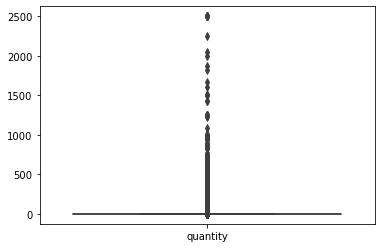

In [83]:
sns.boxplot(data=quantity_mean)

<AxesSubplot:>

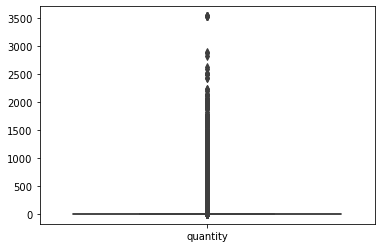

In [92]:
sns.boxplot(data=quantity_std.dropna())

Well, someone really likes to buy A LOT, there isn't even point to look at the sum as it would look somelike similar

<AxesSubplot:>

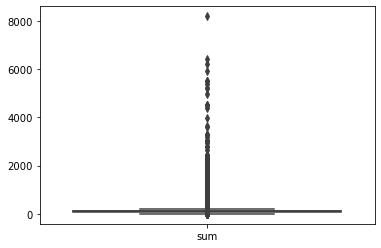

In [94]:
sns.boxplot(data=sum_mean)

<AxesSubplot:>

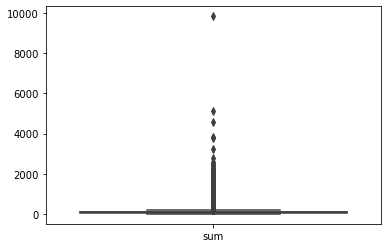

In [91]:
sns.boxplot(data=sum_std.dropna())

In [115]:
sum_std[(sum_std > 8000)['sum'] & (~sum_std.isnull()['sum'])]

,sum
id_card,
A634010,9843.177286


In [122]:
(sum_std[(sum_std > 8000)['sum'] & (~sum_std.isnull()['sum'])])

'A634010   '

In [139]:
df[df.id_card=='A634010']

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
37239031,2020-09-28 15:32:19,C742CB6B-8701-EB11-B444-005056A7539A,0,A634010,21379,15189.0,5.0,12000.0,0
37239032,2020-09-28 15:33:25,CB42CB6B-8701-EB11-B444-005056A7539A,0,A634010,21379,15189.0,5.0,12000.0,0
37242083,2020-09-28 14:00:04,1FF3AD16-7A01-EB11-B444-005056A7539A,0,A634010,21379,15189.0,2.0,4800.0,0
37393902,2020-09-28 13:29:03,9563B6EF-7601-EB11-B444-005056A7539A,0,A634010,21379,15189.0,1.0,1800.6,1
37404403,2020-09-28 16:05:19,14486D8B-8B01-EB11-B444-005056A7539A,0,A634010,21379,15189.0,2.0,4800.0,0
37753376,2020-09-28 08:36:51,9B6A36BF-4C01-EB11-B444-005056A7539A,6518049,A634010,647,13567.0,1.0,5.0,0
37754858,2020-09-28 08:36:51,9B6A36BF-4C01-EB11-B444-005056A7539A,6518049,A634010,21379,15189.0,4.0,9600.0,0
37754859,2020-09-28 08:36:51,9B6A36BF-4C01-EB11-B444-005056A7539A,6518049,A634010,21379,18018.0,16.0,38400.0,0
37764092,2020-09-28 12:30:21,62FE2F59-6E01-EB11-B444-005056A7539A,0,A634010,21379,15189.0,3.0,7200.0,0
37909629,2020-09-28 13:08:28,A468D059-7301-EB11-B444-005056A7539A,0,A634010,647,-9999.0,1.0,5.0,0


In [140]:
df.to_csv('data/products_20200901.csv', index=False)

The quantity isn't much, but the items are pricey. There isn't much to draw from it, i just was too curious about the reason why his std was that big

In [130]:
quantity_mean[(quantity_mean > 1500)['quantity']]

,quantity
id_card,
0485070,1500.500000
1105449,2500.500000
2630262,2500.500000
3145529,2250.386000
3772368,2500.500000
4078401,1500.500000
4656256,1875.666500
5058171,2050.500000
5275663,2000.500000


The value '2500.5' shows a lot, what is it?

In [131]:
quantity_mean[(quantity_mean == 2500.5)['quantity']]

,quantity
id_card,
1105449,2500.5
2630262,2500.5
3772368,2500.5
7435995,2500.5
8264861,2500.5
9831077,2500.5
B477175,2500.5


In [151]:
list(quantity_mean[(quantity_mean == 2500.5)['quantity']].index)

['1105449', '2630262', '3772368', '7435995', '8264861', '9831077', 'B477175']

In [157]:
df[df.id_card == '1105449']

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
9660284,2020-09-08 18:25:45,CCC5C2E7-E8F1-EA11-B444-005056A7539A,0,1105449,647,-9999.0,1.0,5.0,0
9660432,2020-09-08 18:25:45,CCC5C2E7-E8F1-EA11-B444-005056A7539A,0,1105449,1113,-9999.0,5000.0,0.0,0


Sometimes sum is zero! Understandable, have a nice day

In [156]:
df[df.id_card.isin(list(quantity_mean[(quantity_mean == 2500.5)['quantity']].index))]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
278491,2020-09-01 12:39:13,5F4D98FE-37EC-EA11-B444-005056A7539A,0,3772368,1113,-9999.0,5000.0,0.0,0
279246,2020-09-01 12:39:13,5F4D98FE-37EC-EA11-B444-005056A7539A,0,3772368,24643,12518.0,1.0,60.0,0
2238986,2020-09-02 17:47:44,AEC82711-2CED-EA11-B444-005056A7539A,0,7435995,173,271.0,1.0,52.0,0
2239415,2020-09-02 17:47:44,AEC82711-2CED-EA11-B444-005056A7539A,0,7435995,1113,-9999.0,5000.0,0.0,0
9660284,2020-09-08 18:25:45,CCC5C2E7-E8F1-EA11-B444-005056A7539A,0,1105449,647,-9999.0,1.0,5.0,0
9660432,2020-09-08 18:25:45,CCC5C2E7-E8F1-EA11-B444-005056A7539A,0,1105449,1113,-9999.0,5000.0,0.0,0
13383102,2020-09-10 13:18:07,04DDC8CF-4FF3-EA11-B444-005056A7539A,0,8264861,1113,-9999.0,5000.0,0.0,0
13383732,2020-09-10 13:18:07,04DDC8CF-4FF3-EA11-B444-005056A7539A,0,8264861,23954,12831.0,1.0,152.0,0
15558748,2020-09-12 21:00:01,B2B44D14-22F5-EA11-B444-005056A7539A,0,9831077,1113,-9999.0,5000.0,0.0,0
15559971,2020-09-12 21:00:01,B2B44D14-22F5-EA11-B444-005056A7539A,0,9831077,31979,15448.0,1.0,67.0,0


Not only that, they have NaN contributor for sum = 0

_$H_0$: every sum=0 has NaN in the contributor_

In [160]:
df[df['sum']==0]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
5986,2020-09-01 10:38:06,0D50603F-26EC-EA11-B444-005056A7539A,5534007,4169759,22492,102.0,1.0,0.0,0
5987,2020-09-01 10:15:59,FD5D2021-23EC-EA11-B444-005056A7539A,5563859,0538248,22492,102.0,1.0,0.0,0
6525,2020-09-01 15:22:32,ACFEAD6F-4EEC-EA11-B444-005056A7539A,5578751,1515864,31719,102.0,1.0,0.0,0
13743,2020-09-01 09:53:21,1632431A-20EC-EA11-B444-005056A7539A,5561085,0966958,22492,102.0,1.0,0.0,0
13745,2020-09-01 15:42:31,E8A839B9-51EC-EA11-B444-005056A7539A,5577896,4593445,22492,102.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...
41762642,2020-09-30 21:11:47,E762DEDA-4803-EB11-B444-005056A7539A,0,5063043,21118,13961.0,1.0,0.0,1
41762876,2020-09-30 21:11:47,E762DEDA-4803-EB11-B444-005056A7539A,0,5063043,24991,13006.0,1.0,0.0,1
41762907,2020-09-30 20:53:36,A70E35BC-4603-EB11-B444-005056A7539A,0,3411600,26512,18131.0,1.0,0.0,1
41763016,2020-09-30 21:11:47,E762DEDA-4803-EB11-B444-005056A7539A,0,5063043,29536,18464.0,1.0,0.0,1


_$H_0$ is rejected_

Anyway its strange, what kind of product may be given for free?

In [162]:
wtf = df[df.id_card.isin(list(quantity_mean[(quantity_mean == 2500.5)['quantity']].index))]

In [166]:
df_merge = pd.merge(
    wtf,
    products,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

In [167]:
df_merge

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group,name_group
0,2020-09-01 12:39:13,5F4D98FE-37EC-EA11-B444-005056A7539A,0,3772368,1113,-9999.0,5000.0,0.0,0,NaN,NaN
1,2020-09-01 12:39:13,5F4D98FE-37EC-EA11-B444-005056A7539A,0,3772368,24643,12518.0,1.0,60.0,0,10031.0,"Квас, лимонады, компоты, кисели"
2,2020-09-02 17:47:44,AEC82711-2CED-EA11-B444-005056A7539A,0,7435995,173,271.0,1.0,52.0,0,10091.0,"Молоко, сливки"
3,2020-09-02 17:47:44,AEC82711-2CED-EA11-B444-005056A7539A,0,7435995,1113,-9999.0,5000.0,0.0,0,NaN,NaN
4,2020-09-08 18:25:45,CCC5C2E7-E8F1-EA11-B444-005056A7539A,0,1105449,647,-9999.0,1.0,5.0,0,10155.0,Упаковка
5,2020-09-08 18:25:45,CCC5C2E7-E8F1-EA11-B444-005056A7539A,0,1105449,1113,-9999.0,5000.0,0.0,0,NaN,NaN
6,2020-09-10 13:18:07,04DDC8CF-4FF3-EA11-B444-005056A7539A,0,8264861,1113,-9999.0,5000.0,0.0,0,NaN,NaN
7,2020-09-10 13:18:07,04DDC8CF-4FF3-EA11-B444-005056A7539A,0,8264861,23954,12831.0,1.0,152.0,0,10103.0,"Сэндвичи, пирожки"
8,2020-09-12 21:00:01,B2B44D14-22F5-EA11-B444-005056A7539A,0,9831077,1113,-9999.0,5000.0,0.0,0,NaN,NaN
9,2020-09-12 21:00:01,B2B44D14-22F5-EA11-B444-005056A7539A,0,9831077,31979,15448.0,1.0,67.0,0,10033.0,"Выпечка, печенье, вафли, пряники"


Oh wow, those 0 cost items aren' even in the products.

_$H_1$: 0-cost products doesn't have groups_

In [ ]:
df_merge = pd.merge(
    df[df['sum']==0],
    products,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

In [169]:
df_merge

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group,name_group
0,2020-09-01 10:38:06,0D50603F-26EC-EA11-B444-005056A7539A,5534007,4169759,22492,102.0,1.0,0.0,0,10023.0,Детское молочное питание
1,2020-09-01 10:15:59,FD5D2021-23EC-EA11-B444-005056A7539A,5563859,0538248,22492,102.0,1.0,0.0,0,10023.0,Детское молочное питание
2,2020-09-01 15:22:32,ACFEAD6F-4EEC-EA11-B444-005056A7539A,5578751,1515864,31719,102.0,1.0,0.0,0,10023.0,Детское молочное питание
3,2020-09-01 09:53:21,1632431A-20EC-EA11-B444-005056A7539A,5561085,0966958,22492,102.0,1.0,0.0,0,10023.0,Детское молочное питание
4,2020-09-01 15:42:31,E8A839B9-51EC-EA11-B444-005056A7539A,5577896,4593445,22492,102.0,1.0,0.0,0,10023.0,Детское молочное питание
...,...,...,...,...,...,...,...,...,...,...,...
25250,2020-09-30 21:11:47,E762DEDA-4803-EB11-B444-005056A7539A,0,5063043,21118,13961.0,1.0,0.0,1,10082.0,"Сырники, запеканки и десерты"
25251,2020-09-30 21:11:47,E762DEDA-4803-EB11-B444-005056A7539A,0,5063043,24991,13006.0,1.0,0.0,1,10099.0,Салаты и закуски
25252,2020-09-30 20:53:36,A70E35BC-4603-EB11-B444-005056A7539A,0,3411600,26512,18131.0,1.0,0.0,1,10008.0,"Торты, пирожные, муссы, суфле"
25253,2020-09-30 21:11:47,E762DEDA-4803-EB11-B444-005056A7539A,0,5063043,29536,18464.0,1.0,0.0,1,10253.0,Булочки и сдоба


_$H_1$ rejected_

Anyway, 0 cost items doesn't really make sense so I will remove all of them as the first step

In [175]:
df = df[df['sum']!=0]

We now need to recompute the quantities as they are cleaned a bit

In [176]:
quantity_mean = df[['id_card', 'quantity']].groupby('id_card').mean()

<AxesSubplot:ylabel='Count'>

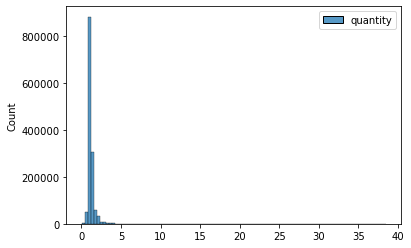

In [180]:
sns.histplot(data=quantity_mean, bins=100)

And boom! now this plot is very boring

In [190]:
sum_mean = df[['id_card', 'sum']].groupby('id_card').mean()

<AxesSubplot:ylabel='Count'>

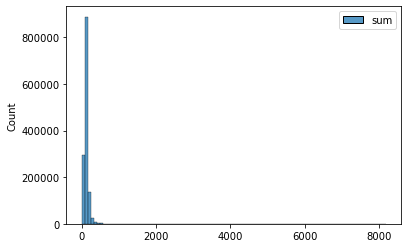

In [191]:
sns.histplot(data=sum_mean, bins=100)

Most likely the values above 2k is outliers, but I understood only now that it might be better to look at the sum.

In [193]:
quantity_sum, sum_sum = df[['id_card', 'quantity']].groupby('id_card').sum(), df[['id_card', 'sum']].groupby('id_card').sum()

<AxesSubplot:>

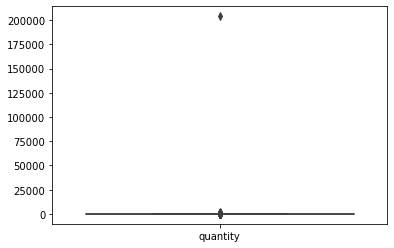

In [196]:
sns.boxplot(data=quantity_sum)

<AxesSubplot:>

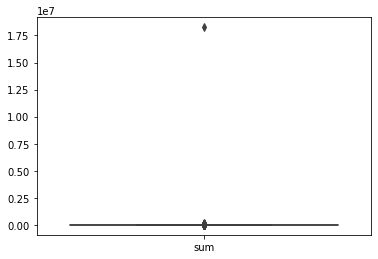

In [198]:
sns.boxplot(data=sum_sum)

??????????????????????????????????????????????????????//

In [199]:
quantity_sum[(quantity_sum>25000) ['quantity']]

,quantity
id_card,
4806534,204087.899


In [203]:
df[df.id_card=='4806534']

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
1209,2020-09-01 13:41:07,AEEFB494-40EC-EA11-B444-005056A7539A,0,4806534,20813,14782.0,1.0,168.0,0
1835,2020-09-01 18:51:35,8A2AD918-6CEC-EA11-B444-005056A7539A,0,4806534,27495,14911.0,1.0,34.0,0
1841,2020-09-01 18:04:23,FEDAE894-65EC-EA11-B444-005056A7539A,0,4806534,27695,15385.0,2.0,152.0,0
1905,2020-09-01 18:51:35,8A2AD918-6CEC-EA11-B444-005056A7539A,0,4806534,29568,13354.0,1.0,36.0,0
1956,2020-09-01 18:04:23,FEDAE894-65EC-EA11-B444-005056A7539A,0,4806534,30560,13614.0,1.0,17.0,0
...,...,...,...,...,...,...,...,...,...
41762992,2020-09-30 17:11:56,AB13A45F-2703-EB11-B444-005056A7539A,0,4806534,28799,15916.0,1.0,130.0,0
41763051,2020-09-30 18:29:17,A586484B-3303-EB11-B444-005056A7539A,0,4806534,30218,12554.0,1.0,185.0,0
41763177,2020-09-30 17:11:56,AB13A45F-2703-EB11-B444-005056A7539A,0,4806534,35061,20817.0,1.0,150.0,0
41763201,2020-09-30 15:55:39,D589FC26-1D03-EB11-B444-005056A7539A,0,4806534,36157,12638.0,1.0,190.0,0


In [211]:
df[df.id_card=='4806534'][['quantity', 'sum']].describe()

,quantity,sum
count,189755.000000,189755.000000
mean,1.075534,96.212395
std,0.525541,60.967805
min,0.004000,0.030000
25%,1.000000,45.000000
50%,1.000000,85.000000
75%,1.000000,142.000000
max,24.000000,756.000000


If this is customer id this is one rich customer buying too much and a lot. I don't think we really need him (he also seems to have a strange case of buying items in very small quantities)

In [213]:
df = df[df.id_card!='4806534']

In [215]:
quantity_sum, sum_sum = df[['id_card', 'quantity']].groupby('id_card').sum(), df[['id_card', 'sum']].groupby('id_card').sum()

<AxesSubplot:>

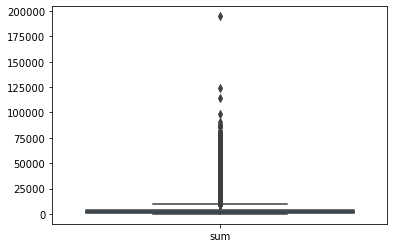

In [217]:
sns.boxplot(data=sum_sum)

Now at least it seems reasonable

However, who would have spend around 50k on the food in the same place? Let's just drop em

In [232]:
df = df[~df.id_card.isin(list(sum_sum[(sum_sum > 50000)['sum']].index))]

In [233]:
quantity_sum, sum_sum = df[['id_card', 'quantity']].groupby('id_card').sum(), df[['id_card', 'sum']].groupby('id_card').sum()

<AxesSubplot:>

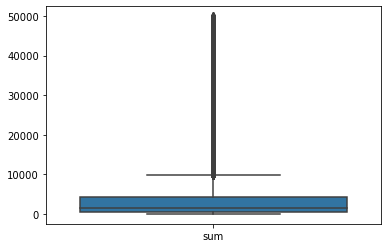

In [234]:
sns.boxplot(data=sum_sum)

<AxesSubplot:>

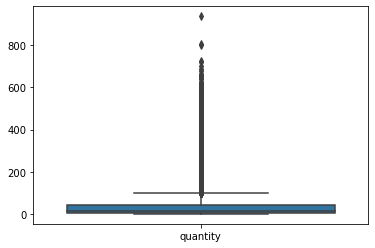

In [235]:
sns.boxplot(data=quantity_sum)

plot thickens...

In [236]:
df.to_csv('data/products_20200901.csv', index=False)

In [237]:
len(df)

41337224

## Other Columns

In [241]:
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271.0,1.0,108.00,0
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271.0,1.0,108.00,0
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271.0,1.0,107.95,0
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271.0,1.0,108.00,0
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97.0,2.0,88.00,0
...,...,...,...,...,...,...,...,...,...
41763569,2020-09-30 11:26:28,350DE9C7-F602-EB11-B444-005056A7539A,0,A465340,25292,17528.0,1.0,130.00,0
41763570,2020-09-30 08:12:39,6D7ACBFB-DB02-EB11-B444-005056A7539A,0,A698682,30740,19188.0,2.0,120.00,0
41763571,2020-09-30 09:54:24,F96D45E8-E902-EB11-B444-005056A7539A,0,7790662,30741,19188.0,1.0,73.00,0
41763572,2020-09-30 12:00:04,12067064-FB02-EB11-B444-005056A7539A,0,2751739,34835,15916.0,1.0,78.00,0


In [19]:
df[['quantity', 'sum']].describe()

,quantity,sum
count,4.133722e+07,4.133722e+07
mean,1.167749e+00,1.152978e+02
std,8.199434e-01,1.069114e+02
min,-2.755000e+00,-1.022110e+03
25%,1.000000e+00,4.860000e+01
50%,1.000000e+00,8.901000e+01
75%,1.000000e+00,1.510000e+02
max,1.270000e+02,9.600000e+03


<AxesSubplot:>

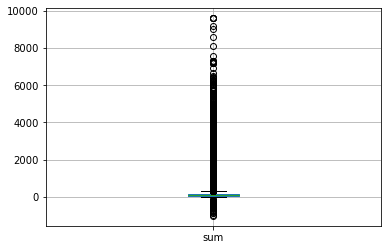

In [20]:
df[['sum']].boxplot()

How come some sums are less then zero?

In [21]:
df[df['sum'] < 0]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
4132879,2020-09-04 09:10:21,827B9591-75EE-EA11-B444-005056A7539A,0,7009929,23074,19269.0,1.268,-470.43,0
4132888,2020-09-04 09:09:24,F6807973-75EE-EA11-B444-005056A7539A,0,7707981,23074,19269.0,1.268,-470.43,0
4136831,2020-09-04 08:37:00,49C21AF5-70EE-EA11-B444-005056A7539A,0,5554550,23074,19269.0,1.084,-402.16,0
4144576,2020-09-04 08:43:37,B681FEE3-71EE-EA11-B444-005056A7539A,0,0643258,23074,19269.0,0.001,-0.37,0
4144578,2020-09-04 08:43:37,B681FEE3-71EE-EA11-B444-005056A7539A,0,0643258,23074,19269.0,2.375,-881.13,0
...,...,...,...,...,...,...,...,...,...
5288527,2020-09-04 09:13:44,8B5F8150-76EE-EA11-B444-005056A7539A,0,8593402,23074,19269.0,0.692,-256.73,0
5302378,2020-09-04 08:37:49,1CC214FB-70EE-EA11-B444-005056A7539A,0,4916790,23074,19269.0,1.236,-458.56,0
5343717,2020-09-04 09:28:21,E6F17E03-78EE-EA11-B444-005056A7539A,0,5931979,23074,19269.0,0.572,-212.21,0
5354760,2020-09-04 09:21:17,CD1BCB2C-77EE-EA11-B444-005056A7539A,0,3290674,23074,19269.0,0.915,-339.47,0


In [22]:
df = df[df['sum'] > 0]

<AxesSubplot:>

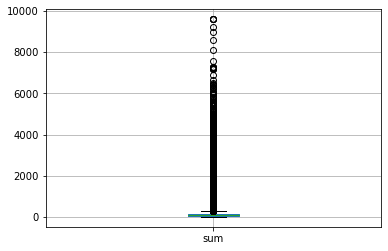

In [23]:
df[['sum']].boxplot()

In [26]:
df_merge = pd.merge(
    df[df['sum'] > 5000],
    products,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

In [28]:
df_merge

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group,name_group
0,2020-09-01 11:33:51,BB7DEE2F-2EEC-EA11-B444-005056A7539A,0,0072076,21379,15189.0,3.0,7200.0,0,10053.0,Икра
1,2020-09-01 08:13:03,1F84BB1B-12EC-EA11-B444-005056A7539A,0,0222500,37421,-9999.0,1.0,5500.0,0,NaN,NaN
2,2020-09-01 08:13:49,EBDAA73F-12EC-EA11-B444-005056A7539A,0,6101053,37806,-9999.0,1.0,5200.0,0,NaN,NaN
3,2020-09-01 08:12:26,5F53F7D3-11EC-EA11-B444-005056A7539A,0,0169045,37810,-9999.0,1.0,5500.0,0,NaN,NaN
4,2020-09-01 11:18:24,A1007023-2CEC-EA11-B444-005056A7539A,0,1146821,37400,-9999.0,2.0,7280.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
92,2020-09-29 08:08:32,FAC6FF23-1202-EB11-B444-005056A7539A,0,5060376,37430,19188.0,1.0,5400.0,0,NaN,NaN
93,2020-09-29 08:09:27,B16CF92F-1202-EB11-B444-005056A7539A,0,5433527,37447,19188.0,1.0,6400.0,0,NaN,NaN
94,2020-09-30 21:33:31,3FABF852-4C03-EB11-B444-005056A7539A,0,A811709,25698,17934.0,28.0,5040.0,0,10089.0,"Пиво, медовуха"
95,2020-09-30 19:47:25,61AF0B25-3E03-EB11-B444-005056A7539A,0,3927472,23239,14188.0,3.0,5520.0,0,10054.0,Пресервы и консервы


Seems like a lot outliers (don't actually know how much 'икра' costs, too afraid to remove it). Need to think if all tovars with NaN in id group should be removed

<AxesSubplot:>

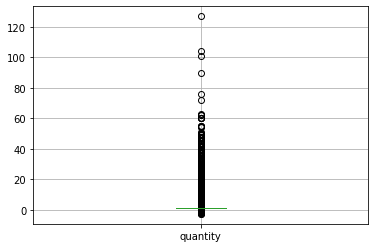

In [30]:
df[['quantity']].boxplot()

negative quantities as well? come on

In [32]:
df = df[df['quantity'] > 0]

<AxesSubplot:>

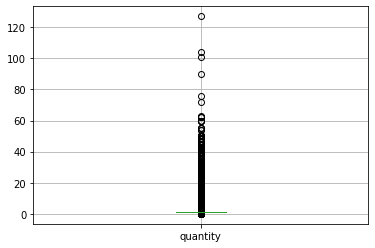

In [33]:
df[['quantity']].boxplot()

In [34]:
df_merge = pd.merge(
    df[df['quantity'] > 60],
    products,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

In [35]:
df_merge

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group,name_group
0,2020-09-02 13:04:34,1C1F5556-04ED-EA11-B444-005056A7539A,0,3222542,21866,-9999.0,90.0,1440.0,0,10155.0,Упаковка
1,2020-09-02 13:22:09,8A981156-07ED-EA11-B444-005056A7539A,0,3222542,21866,-9999.0,127.0,2032.0,0,10155.0,Упаковка
2,2020-09-05 17:54:11,9E2B66EA-87EF-EA11-B444-005056A7539A,0,5111367,23237,14851.0,104.0,104.0,0,NaN,NaN
3,2020-09-07 12:35:31,471A2862-EEF0-EA11-B444-005056A7539A,0,2621665,20494,-9999.0,72.0,1296.0,0,10026.0,"Соки, нектары и вода для детей"
4,2020-09-18 15:10:29,0F737A81-A8F9-EA11-B444-005056A7539A,0,2099611,24774,-9999.0,76.0,1140.0,0,10034.0,"Леденцы, мармелад, халва, зефир, восточные сла..."
5,2020-09-18 13:04:01,159EB75E-97F9-EA11-B444-005056A7539A,0,7915602,19730,14035.0,62.0,2666.0,0,10116.0,"Снеки, батончики"
6,2020-09-18 12:59:44,300009D5-95F9-EA11-B444-005056A7539A,0,7915602,19730,14035.0,62.0,2666.0,0,10116.0,"Снеки, батончики"
7,2020-09-20 15:19:37,76173AE2-3BFB-EA11-B444-005056A7539A,0,0074781,21305,15093.0,63.0,2457.0,0,10035.0,"Карамель, шоколад, конфеты"
8,2020-09-22 09:52:49,89A0CA6A-A0FC-EA11-B444-005056A7539A,0,1060195,647,-9999.0,101.0,505.0,0,10155.0,Упаковка


Transcation 5-6 is shady, but i don't know how to properly remove such transactions right now

In [38]:
df[df.id_card=='7915602']['sum'].sum()

7865.23

In [39]:
df = df[df['quantity'] < 60]

In [40]:
df = df[df['sum'] < 7000]

In [41]:
df.to_csv('data/products_20200901.csv', index=False)

## Id_tov

In [42]:
mean_id_tov, max_id_tov = df[['id_tov', 'quantity', 'sum']].groupby('id_tov').mean(), df[['id_tov', 'quantity', 'sum']].groupby('id_tov').max()

In [45]:
len(mean_id_tov), len(products)

(6071, 5650)

hmmmmmm, some products don't have their description, how much orders are like this?

In [48]:
df_merge = pd.merge(
    mean_id_tov,
    products,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

In [52]:
df_merge

,id_tov,quantity,sum,id_group,name_group
0,46,0.283735,195.801128,10079.0,Сливочное масло
1,52,1.100616,113.919229,10004.0,Кисломолочные продукты
2,61,1.481643,77.652738,10091.0,"Молоко, сливки"
3,69,0.341163,145.624668,10082.0,"Сырники, запеканки и десерты"
4,71,0.260062,125.437802,10128.0,"Мягкие, плавленые и рассольные сыры"
...,...,...,...,...,...
6090,38546,0.509333,607.348571,10051.0,Замороженные морепродукты
6091,38587,0.840659,70.661351,NaN,NaN
6092,38618,0.237805,34.228783,NaN,NaN
6093,38645,0.729000,105.778333,NaN,NaN


In [53]:
df_merge[df_merge.id_group.isnull()]

,id_tov,quantity,sum,id_group,name_group
44,369,1.000000,131.996000,NaN,NaN
51,480,0.292355,169.201979,NaN,NaN
71,615,0.061000,24.095000,NaN,NaN
72,616,0.040000,12.250000,NaN,NaN
73,617,0.529736,280.412872,NaN,NaN
...,...,...,...,...,...
6088,38514,0.280545,202.978182,NaN,NaN
6089,38531,1.000000,108.326667,NaN,NaN
6091,38587,0.840659,70.661351,NaN,NaN
6092,38618,0.237805,34.228783,NaN,NaN


(not equal to 6071-5650 as I've done a left join and some type of products wasn't bought)

<AxesSubplot:>

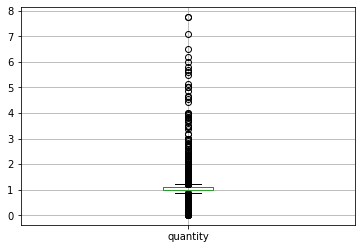

In [57]:
df_merge[df_merge.id_group.isnull()][['quantity']].boxplot()

<AxesSubplot:>

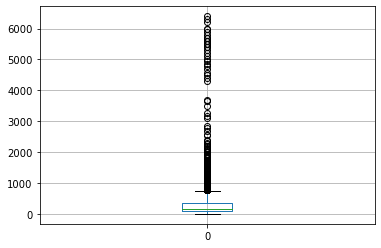

In [62]:
pd.DataFrame(df_merge[df_merge.id_group.isnull()]['sum']/df_merge[df_merge.id_group.isnull()]['quantity']).boxplot()

Those are mostly very expensive items

In [64]:
tovs = df_merge[df_merge.id_group.isnull()].id_tov

df[df.id_tov.isin(tovs)]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
131,2020-09-01 21:12:18,367A0D60-7FEC-EA11-B444-005056A7539A,0,9790655,480,133.0,0.290,115.54,1
132,2020-09-01 17:28:13,917CC7F1-5FEC-EA11-B444-005056A7539A,0,0409629,480,133.0,0.258,102.79,1
195,2020-09-01 10:59:38,389B9352-29EC-EA11-B444-005056A7539A,0,5159017,628,17394.0,0.400,59.18,0
360,2020-09-01 21:11:43,35DD1CC5-7EEC-EA11-B444-005056A7539A,0,8880297,654,17616.0,0.772,127.38,0
361,2020-09-01 19:06:25,76074FDE-6EEC-EA11-B444-005056A7539A,0,7632964,654,17616.0,0.806,132.99,0
...,...,...,...,...,...,...,...,...,...
41337162,2020-09-30 13:16:59,A8CE044A-0603-EB11-B444-005056A7539A,0,5197698,37083,12554.0,1.000,185.00,0
41337190,2020-09-30 15:23:37,4BC8A6EF-1703-EB11-B444-005056A7539A,0,9035419,14562,13990.0,1.000,123.00,0
41337196,2020-09-30 20:15:19,F165819C-4003-EB11-B444-005056A7539A,0,A857014,25684,-9999.0,1.000,3.00,0
41337198,2020-09-30 13:08:22,7F6FEDEF-0403-EB11-B444-005056A7539A,0,3573574,14562,13990.0,1.000,123.00,0


This may be a contradictory move, but I will drop those rows as they wouldn't be described later when using products

In [66]:
df = df[~df.id_tov.isin(tovs)]

In [73]:
mean_id_tov, max_id_tov, sum_id_tov = df[['id_tov', 'quantity', 'sum']].groupby('id_tov').mean(), df[['id_tov', 'quantity', 'sum']].groupby('id_tov').max(), df[['id_tov', 'quantity', 'sum']].groupby('id_tov').sum()

In [69]:
mean_id_tov

,quantity,sum
id_tov,,
46,0.283735,195.801128
52,1.100616,113.919229
61,1.481643,77.652738
69,0.341163,145.624668
71,0.260062,125.437802
...,...,...
38395,1.000000,84.852857
38398,1.000000,89.992500
38459,1.000000,67.591667


In [74]:
df_merge = pd.merge(
    sum_id_tov,
    products,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

In [75]:
df_merge

,id_tov,quantity,sum,id_group,name_group
0,46,797.580,5.503970e+05,10079,Сливочное масло
1,52,102081.000,1.056589e+07,10004,Кисломолочные продукты
2,61,368181.000,1.929632e+07,10091,"Молоко, сливки"
3,69,18219.827,7.777085e+06,10082,"Сырники, запеканки и десерты"
4,71,1786.628,8.617577e+05,10128,"Мягкие, плавленые и рассольные сыры"
...,...,...,...,...,...
4214,38395,7.000,5.939700e+02,10067,"Зелень, салаты, снеки"
4215,38398,16.000,1.439880e+03,10067,"Зелень, салаты, снеки"
4216,38459,6.000,4.055500e+02,10069,"Фрукты, ягоды, бахчевые"
4217,38546,10.696,1.275432e+04,10051,Замороженные морепродукты


In [77]:
df_merge.sort_values('quantity',ascending=False)[:5]

,id_tov,quantity,sum,id_group,name_group
74,647,2780241.000,1.388202e+07,10155,Упаковка
15,173,489232.000,2.425019e+07,10091,"Молоко, сливки"
2,61,368181.000,1.929632e+07,10091,"Молоко, сливки"
92,731,338236.983,2.815448e+07,10069,"Фрукты, ягоды, бахчевые"
238,14526,317281.000,1.909998e+07,10004,Кисломолочные продукты


This is top 5 most frequently bought products

In [80]:
pd.DataFrame((df_merge['sum']/df_merge.quantity)).sort_values(0,ascending=False)[:5]

,0
1868,4050.000000
1642,2739.972333
4054,2563.105352
1139,2546.599277
3270,2206.870506


Those are really expensive 'ypakovkas', don't really know the reason.

<AxesSubplot:>

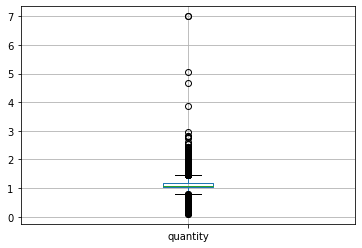

In [84]:
mean_id_tov[['quantity']].boxplot()

<AxesSubplot:>

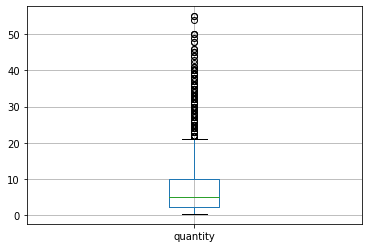

In [85]:
max_id_tov[['quantity']].boxplot()

<AxesSubplot:>

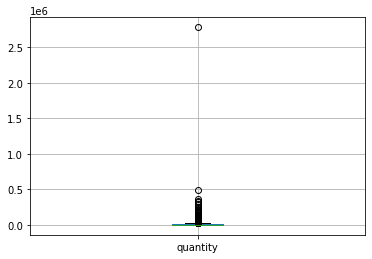

In [88]:
sum_id_tov[['quantity']].boxplot()

In [92]:
pd.merge(
    sum_id_tov[sum_id_tov.quantity > 0.4e6],
    products,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

,id_tov,quantity,sum,id_group,name_group
0,173,489232.0,2.425019e+07,10091,"Молоко, сливки"
1,647,2780241.0,1.388202e+07,10155,Упаковка


In [93]:
df[df.id_tov.isin([173,647])]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
48,2020-09-01 19:47:25,0C34A539-74EC-EA11-B444-005056A7539A,0,3225142,173,379.0,1.0,52.00,0
49,2020-09-01 19:59:25,2D5F3D16-75EC-EA11-B444-005056A7539A,0,4940905,173,271.0,1.0,51.97,0
50,2020-09-01 17:46:51,5C2CE045-62EC-EA11-B444-005056A7539A,0,0409803,173,13426.0,2.0,104.00,0
51,2020-09-01 10:10:14,65FBF067-22EC-EA11-B444-005056A7539A,0,0869804,173,13426.0,1.0,52.00,0
52,2020-09-01 21:11:16,778F4949-7FEC-EA11-B444-005056A7539A,0,2924832,173,13426.0,2.0,104.00,0
...,...,...,...,...,...,...,...,...,...
41335725,2020-09-30 17:48:41,06E0904F-2D03-EB11-B444-005056A7539A,6661355,5483032,647,13362.0,2.0,10.00,0
41335726,2020-09-30 17:52:40,DB6DFA29-2E03-EB11-B444-005056A7539A,6662529,8237428,647,13362.0,1.0,5.00,0
41335727,2020-09-30 18:42:54,8EF3F839-3503-EB11-B444-005056A7539A,6665318,4116383,647,13362.0,1.0,5.00,0
41335728,2020-09-30 19:06:03,416EF270-3803-EB11-B444-005056A7539A,6666651,5342824,647,13362.0,2.0,10.00,0


They doesnt look like outliers at all

<AxesSubplot:>

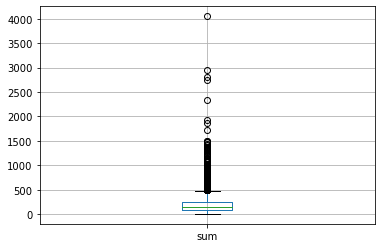

In [97]:
mean_id_tov[['sum']].boxplot()

<AxesSubplot:>

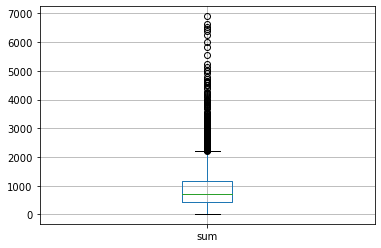

In [95]:
max_id_tov[['sum']].boxplot()

<AxesSubplot:>

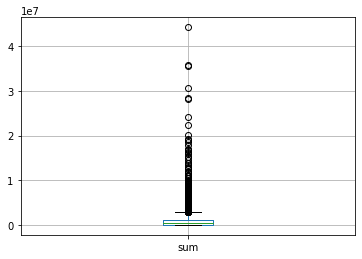

In [96]:
sum_id_tov[['sum']].boxplot()

p.s. I am already too bored to look into those items..

In [128]:
count_tovs = df[['id_tov', 'quantity']].groupby('id_tov').count()

Ypakovka is really popular

<AxesSubplot:>

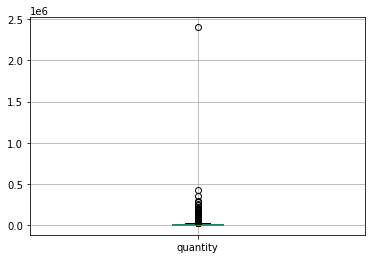

In [129]:
count_tovs[['quantity']].boxplot()

In [130]:
count_tovs[count_tovs.quantity > 1e6]

,quantity
id_tov,
647,2403491


Items that were bought once aren't really interesting

In [138]:
count_tovs[count_tovs.quantity == 1]

,quantity
id_tov,
16468,1
17333,1
20375,1
24269,1
27379,1
...,...
38102,1
38103,1
38124,1


In [137]:
df[df.id_tov.isin(list(count_tovs[count_tovs.quantity == 1].index))]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
567114,2020-09-01 21:23:49,4430616C-80EC-EA11-B444-005056A7539A,0,B148868,34306,20310.0,1.00,80.0,0
632359,2020-09-01 19:25:16,C8CBC23A-71EC-EA11-B444-005056A7539A,0,9759289,29926,18604.0,1.00,459.0,0
632360,2020-09-01 07:47:32,60AF817A-0EEC-EA11-B444-005056A7539A,0,7720712,29935,18604.0,1.00,449.0,0
632361,2020-09-01 10:32:37,41EAD8B0-25EC-EA11-B444-005056A7539A,0,7118042,29941,18604.0,1.00,449.0,0
704602,2020-09-01 09:48:46,24BD4B62-1FEC-EA11-B444-005056A7539A,0,3733358,30647,18604.0,1.00,999.0,0
...,...,...,...,...,...,...,...,...,...
39009133,2020-09-29 11:45:58,C397164B-3002-EB11-B444-005056A7539A,0,0801150,27726,18604.0,1.00,459.0,0
40593773,2020-09-30 10:08:12,6F8D9B07-EC02-EB11-B444-005056A7539A,0,9384828,30915,18604.0,1.00,679.0,0
40605443,2020-09-30 14:30:02,A0766417-1103-EB11-B444-005056A7539A,0,4975898,33652,18493.0,1.00,355.0,0
40822966,2020-09-30 21:08:06,49771A87-4803-EB11-B444-005056A7539A,0,3110576,31693,19964.0,1.00,499.0,0


In [139]:
df = df[~df.id_tov.isin(list(count_tovs[count_tovs.quantity == 1].index))]

In [142]:
df_merge = pd.merge(
    count_tovs[count_tovs.quantity != 1],
    products,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

In [143]:
df_merge.sort_values('quantity', ascending=False)

,id_tov,quantity,id_group,name_group
74,647,2403491,10155,Упаковка
92,731,421303,10069,"Фрукты, ягоды, бахчевые"
15,173,351952,10091,"Молоко, сливки"
238,14526,288638,10004,Кисломолочные продукты
67,609,279758,10068,"Овощи, грибы, проростки"
...,...,...,...,...
2114,27790,2,10464,Детская одежда
2752,30893,2,10464,Детская одежда
2753,30899,2,10464,Детская одежда
2115,27791,2,10464,Детская одежда


Most popular items to buy

## Id_kontr

In [131]:
sum_id_kontr = df[['id_kontr', 'quantity', 'sum']].groupby('id_kontr').sum()

<AxesSubplot:>

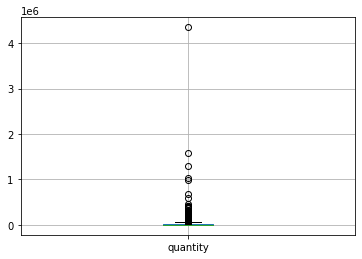

In [111]:
sum_id_kontr[['quantity']].boxplot()

<AxesSubplot:>

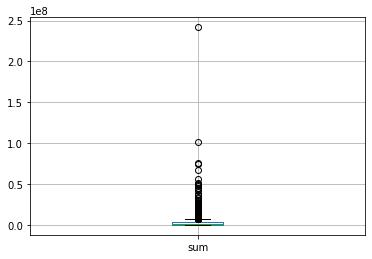

In [112]:
sum_id_kontr[['sum']].boxplot()

In [113]:
sum_id_kontr[sum_id_kontr.quantity > 1e6]

,quantity,sum
id_kontr,,
-9999.0,4347364.197,2.418448e+08
102.0,1305632.000,4.542505e+07
271.0,1022949.000,6.757182e+07
339.0,1579704.000,7.565079e+07


In [114]:
df[df.id_kontr.isin([102,271,339])]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271.0,1.0,108.00,0
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271.0,1.0,108.00,0
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271.0,1.0,107.95,0
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271.0,1.0,108.00,0
5,2020-09-01 12:47:31,0B25F727-39EC-EA11-B444-005056A7539A,0,2102075,61,271.0,4.0,224.00,0
...,...,...,...,...,...,...,...,...,...
41337151,2020-09-30 08:38:43,AE40F44F-DF02-EB11-B444-005056A7539A,0,7215472,15433,339.0,1.0,40.00,0
41337153,2020-09-30 09:00:13,2755F750-E202-EB11-B444-005056A7539A,0,2650011,23024,339.0,1.0,40.00,0
41337206,2020-09-30 16:09:58,C150BA5C-1E03-EB11-B444-005056A7539A,0,C526660,16319,102.0,1.0,52.00,0
41337213,2020-09-30 10:47:53,0929655B-F102-EB11-B444-005056A7539A,0,2193871,23024,339.0,1.0,40.00,0


Most popular contributors

In [146]:
df.to_csv('data/products_20200901.csv', index=False)

## Descriptives

### ID_doc

We will need to split the doc id as it `may` contain some information.
As some of them aren't unique i will retain the original field

And i'm already too frustrated to get to know what those values mean so...

In [147]:
df.id_doc.nunique()

7511469

In [148]:
split = df.id_doc.str.split('-', expand = True)

In [149]:
df['id_doc_1'] = split[0]
df['id_doc_2'] = split[1]
df['id_doc_3'] = split[2]
df['id_doc_4'] = split[3]
df['id_doc_5'] = split[4]

In [150]:
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_doc_1,id_doc_2,id_doc_3,id_doc_4,id_doc_5
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271.0,1.0,108.00,0,0E05D308,5CEC,EA11,B444,005056A7539A
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271.0,1.0,108.00,0,610205A1,61EC,EA11,B444,005056A7539A
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271.0,1.0,107.95,0,8AF19602,70EC,EA11,B444,005056A7539A
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271.0,1.0,108.00,0,EB6C71A3,84EC,EA11,B444,005056A7539A
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97.0,2.0,88.00,0,0706023F,6BEC,EA11,B444,005056A7539A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41337219,2020-09-30 11:26:28,350DE9C7-F602-EB11-B444-005056A7539A,0,A465340,25292,17528.0,1.0,130.00,0,350DE9C7,F602,EB11,B444,005056A7539A
41337220,2020-09-30 08:12:39,6D7ACBFB-DB02-EB11-B444-005056A7539A,0,A698682,30740,19188.0,2.0,120.00,0,6D7ACBFB,DB02,EB11,B444,005056A7539A
41337221,2020-09-30 09:54:24,F96D45E8-E902-EB11-B444-005056A7539A,0,7790662,30741,19188.0,1.0,73.00,0,F96D45E8,E902,EB11,B444,005056A7539A
41337222,2020-09-30 12:00:04,12067064-FB02-EB11-B444-005056A7539A,0,2751739,34835,15916.0,1.0,78.00,0,12067064,FB02,EB11,B444,005056A7539A


It might also be a good idea to split the date into date and time (e.g. if one would want to find most popular shopping time)

In [153]:
df['datetime'] = df['date']

In [156]:
df['time'] = pd.to_datetime(df['datetime']).dt.time

In [204]:
df['date'] = pd.to_datetime(df['datetime']).dt.date

In [205]:
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_doc_1,id_doc_2,id_doc_3,id_doc_4,id_doc_5,datetime,time,cost_per_item
0,2020-09-01,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271.0,1.0,108.00,0,0E05D308,5CEC,EA11,B444,005056A7539A,2020-09-01 17:01:25,17:01:25,108.00
1,2020-09-01,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271.0,1.0,108.00,0,610205A1,61EC,EA11,B444,005056A7539A,2020-09-01 17:35:36,17:35:36,108.00
2,2020-09-01,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271.0,1.0,107.95,0,8AF19602,70EC,EA11,B444,005056A7539A,2020-09-01 19:19:21,19:19:21,107.95
3,2020-09-01,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271.0,1.0,108.00,0,EB6C71A3,84EC,EA11,B444,005056A7539A,2020-09-01 21:53:34,21:53:34,108.00
4,2020-09-01,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97.0,2.0,88.00,0,0706023F,6BEC,EA11,B444,005056A7539A,2020-09-01 18:42:31,18:42:31,44.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41337219,2020-09-30,350DE9C7-F602-EB11-B444-005056A7539A,0,A465340,25292,17528.0,1.0,130.00,0,350DE9C7,F602,EB11,B444,005056A7539A,2020-09-30 11:26:28,11:26:28,130.00
41337220,2020-09-30,6D7ACBFB-DB02-EB11-B444-005056A7539A,0,A698682,30740,19188.0,2.0,120.00,0,6D7ACBFB,DB02,EB11,B444,005056A7539A,2020-09-30 08:12:39,08:12:39,60.00
41337221,2020-09-30,F96D45E8-E902-EB11-B444-005056A7539A,0,7790662,30741,19188.0,1.0,73.00,0,F96D45E8,E902,EB11,B444,005056A7539A,2020-09-30 09:54:24,09:54:24,73.00
41337222,2020-09-30,12067064-FB02-EB11-B444-005056A7539A,0,2751739,34835,15916.0,1.0,78.00,0,12067064,FB02,EB11,B444,005056A7539A,2020-09-30 12:00:04,12:00:04,78.00


Now let's calculate discount on particular product using a very dumb (cool) idea - the discount aren't very frequent and the real price is

In [188]:
df['cost_per_item'] = df['sum']/df['quantity']

In [190]:
modes = df[['id_tov', 'cost_per_item']].groupby('id_tov')['cost_per_item'].agg(pd.Series.mode).to_frame()

In [191]:
modes

,cost_per_item
id_tov,
46,815
52,108
61,56
69,470
71,511
...,...
38394,90
38395,90
38398,90


In [194]:
import numpy as np

for i, row in modes.iterrows():
    if type(row[0]) == np.float64:
        continue
    else:
        modes.at[i,'cost_per_item'] = np.max(row[0])

In [195]:
modes = modes.astype(float)

<AxesSubplot:>

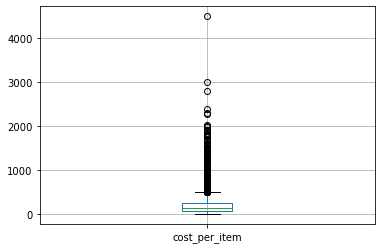

In [197]:
modes.boxplot()

In [199]:
modes[modes.cost_per_item==4500]

,cost_per_item
id_tov,
26191,4500.0


In [200]:
pd.merge(
    modes[modes.cost_per_item==4500],
    products,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

,id_tov,cost_per_item,id_group,name_group
0,26191,4500.0,10386,Сувенирная продукция


Some very expensive souvenirs they've got there

In [206]:
df = pd.merge(
    df,
    modes,
    how="left",
    on='id_tov',
    sort=False,
    suffixes=("_first", "_second"),
    copy=False,
)

In [207]:
df['discount'] = (df.cost_per_item_second-df.cost_per_item_first)/df.cost_per_item_second

In [208]:
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_doc_1,id_doc_2,id_doc_3,id_doc_4,id_doc_5,datetime,time,cost_per_item_first,cost_per_item_second,discount
0,2020-09-01,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271.0,1.0,108.00,0,0E05D308,5CEC,EA11,B444,005056A7539A,2020-09-01 17:01:25,17:01:25,108.00,108.0,0.000000
1,2020-09-01,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271.0,1.0,108.00,0,610205A1,61EC,EA11,B444,005056A7539A,2020-09-01 17:35:36,17:35:36,108.00,108.0,0.000000
2,2020-09-01,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271.0,1.0,107.95,0,8AF19602,70EC,EA11,B444,005056A7539A,2020-09-01 19:19:21,19:19:21,107.95,108.0,0.000463
3,2020-09-01,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271.0,1.0,108.00,0,EB6C71A3,84EC,EA11,B444,005056A7539A,2020-09-01 21:53:34,21:53:34,108.00,108.0,0.000000
4,2020-09-01,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97.0,2.0,88.00,0,0706023F,6BEC,EA11,B444,005056A7539A,2020-09-01 18:42:31,18:42:31,44.00,56.0,0.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38961321,2020-09-30,350DE9C7-F602-EB11-B444-005056A7539A,0,A465340,25292,17528.0,1.0,130.00,0,350DE9C7,F602,EB11,B444,005056A7539A,2020-09-30 11:26:28,11:26:28,130.00,130.0,0.000000
38961322,2020-09-30,6D7ACBFB-DB02-EB11-B444-005056A7539A,0,A698682,30740,19188.0,2.0,120.00,0,6D7ACBFB,DB02,EB11,B444,005056A7539A,2020-09-30 08:12:39,08:12:39,60.00,60.0,0.000000
38961323,2020-09-30,F96D45E8-E902-EB11-B444-005056A7539A,0,7790662,30741,19188.0,1.0,73.00,0,F96D45E8,E902,EB11,B444,005056A7539A,2020-09-30 09:54:24,09:54:24,73.00,73.0,0.000000
38961324,2020-09-30,12067064-FB02-EB11-B444-005056A7539A,0,2751739,34835,15916.0,1.0,78.00,0,12067064,FB02,EB11,B444,005056A7539A,2020-09-30 12:00:04,12:00:04,78.00,78.0,0.000000
